In [ ]:
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import tensorflow.compat.v1 as tfv1
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/OSU/CS467_shared'

/content/drive/My Drive/Colab Notebooks/OSU/CS467_shared


In [ ]:
label_strings = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
IMG_PIXELS = 67000
GTZAN_dataset = tf.data.experimental.load('./Data/GTZAN_dataset',(tf.TensorSpec(shape=(IMG_PIXELS,), dtype=tf.int32, name=None), tf.TensorSpec(shape=(), dtype=tf.int32, name=None)))

In [ ]:
images = []
labels = []
for x, y in GTZAN_dataset:
  images.append(x.numpy())
  labels.append(y.numpy())

images = np.array(images)
labels = np.array(labels)

In [ ]:
# define test and train data set
test_split = .2
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels= train_test_split(images, labels, test_size = test_split, random_state=42)

In [ ]:
# Normalize pixel values to be between 0 and 1 and reshape
img_width = 335 
img_height = 200 
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images.reshape(train_images.shape[0], img_height, img_width, 1)
test_images = test_images.reshape(test_images.shape[0], img_height, img_width, 1)

# one hot encode labels
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

In [ ]:
data = pd.read_csv('./Data/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
genre_list = data.iloc[:, -1]
feat_labels = []
for x in genre_list:
  feat_labels.append(label_strings.index(x))

feat_labels = np.array(feat_labels)

data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
feat_values = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

feat_train_values, feat_test_values, feat_train_labels, feat_test_labels = train_test_split(feat_values, feat_labels, test_size=test_split, random_state=42)
feat_train_labels = tf.keras.utils.to_categorical(feat_train_labels, 10)
feat_test_labels = tf.keras.utils.to_categorical(feat_test_labels, 10)


In [ ]:
print(np.array_equal(train_labels, feat_train_labels))
print(np.array_equal(test_labels, feat_test_labels))

True
True


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


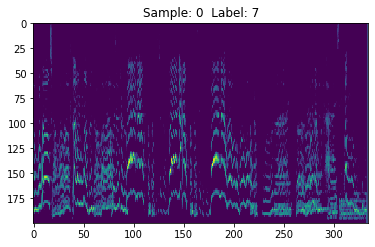

In [ ]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the lots of values to a 423x288 image
    image = train_images[num].reshape([img_height, img_width])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image) #, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(0)

In [ ]:
# feature layers
feat_input = keras.Input(shape=(feat_train_values.shape[1],), name='feat_input')
x = keras.layers.Dense(256, activation='relu')(feat_input)
x = keras.layers.Dense(128, activation='relu')(x)
feat_layers = keras.layers.Dense(64, activation='relu')(x)

# image convolutional layers
img_input = keras.Input(shape=(img_height, img_width, 1), name="img_input")
x = keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(img_input)
x = keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Flatten()(x)
img_layers = keras.layers.Dropout(0.5)(x)

# concatenate img layers with feature layers and define output layer
combined = keras.layers.concatenate([img_layers, feat_layers])
out_layer = keras.layers.Dense(10, activation='softmax')(combined)

# define model with both image and feature inputs
model = keras.Model(inputs=[feat_input, img_input], outputs=out_layer)

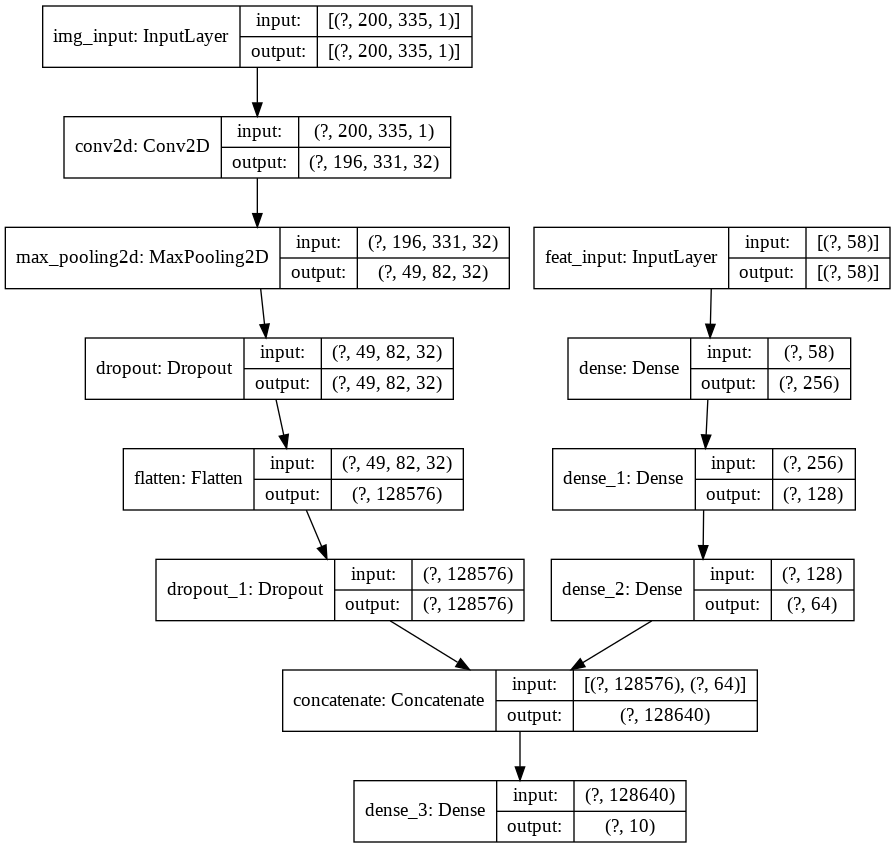

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 200, 335, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 196, 331, 32) 832         img_input[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 49, 82, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
feat_input (InputLayer)         [(None, 58)]         0                                            
_______________________________________________________________________________________

In [ ]:
# compile model
model.compile(optimizer='adam',
          loss=keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

# train model
BATCH_SIZE = 32 
NUM_EPOCHS = 20 

In [ ]:
  print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
  print(feat_train_values.shape, feat_train_labels.shape, feat_test_values.shape, feat_test_labels.shape)

(799, 200, 335, 1) (799, 10) (200, 200, 335, 1) (200, 10)
(799, 58) (799, 10) (200, 58) (200, 10)


In [ ]:
# fit model
history = model.fit(x=[feat_train_values, train_images], y=train_labels, 
                    validation_data=([feat_test_values, test_images], test_labels), 
                    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS) 

Epoch 1/20
25/25 [==============================] - 1s 27ms/step - loss: 2.1082 - accuracy: 0.3104 - val_loss: 1.6485 - val_accuracy: 0.4050
Epoch 2/20
25/25 [==============================] - 0s 16ms/step - loss: 1.0267 - accuracy: 0.6583 - val_loss: 1.1070 - val_accuracy: 0.5950
Epoch 3/20
25/25 [==============================] - 0s 16ms/step - loss: 0.6021 - accuracy: 0.8285 - val_loss: 0.9305 - val_accuracy: 0.6450
Epoch 4/20
25/25 [==============================] - 0s 17ms/step - loss: 0.3407 - accuracy: 0.9237 - val_loss: 0.8223 - val_accuracy: 0.7100
Epoch 5/20
25/25 [==============================] - 0s 16ms/step - loss: 0.1806 - accuracy: 0.9700 - val_loss: 0.7813 - val_accuracy: 0.7450
Epoch 6/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0867 - accuracy: 0.9950 - val_loss: 0.8194 - val_accuracy: 0.7300
Epoch 7/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0526 - accuracy: 0.9987 - val_loss: 0.7278 - val_accuracy: 0.7600
Epoch 8/20
25

7/7 - 0s - loss: 0.7637 - accuracy: 0.7750


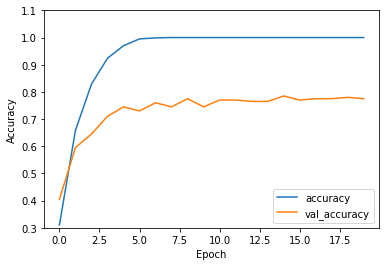

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate([feat_test_values, test_images], test_labels, verbose=2)

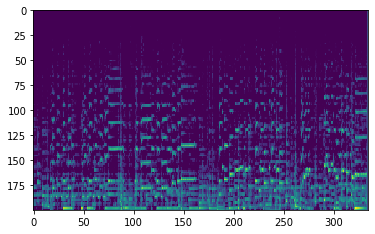

In [ ]:
# test = model.predict(test_images[0].reshape([img_height, img_width]))
num = 5
test = test_images[num].reshape([img_height, img_width])
plt.imshow(test)
plt.show()

In [ ]:
prediction = model.predict([np.array([feat_test_values[num]]), np.array([test_images[num]])])
prediction

array([[3.0942883e-05, 1.0476826e-02, 2.4064468e-02, 1.7048557e-06,
        1.6620775e-09, 9.6502465e-01, 2.5607801e-12, 3.1806126e-06,
        5.2989639e-05, 3.4515560e-04]], dtype=float32)

In [ ]:
# top 3 predictions
top3 = np.argsort(-prediction[0])[:3]
for i, val in enumerate(top3, start=1):
  print('#{}: {}'.format(i, label_strings[val]))

#1: jazz
#2: country
#3: classical


In [ ]:
# actual label
# print(labels[test_labels[img_num]])
print(test_labels[num])
print(label_strings[np.argmax(test_labels[num])])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
jazz
